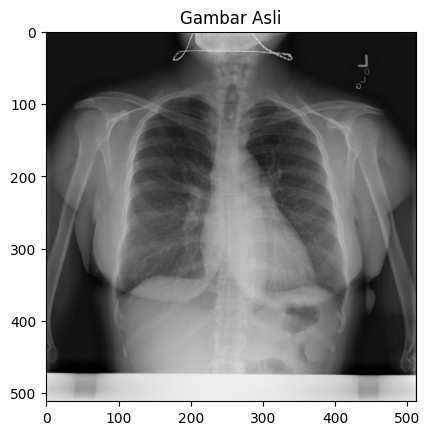

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import segmentation, measure
from sklearn.cluster import KMeans

%matplotlib inline

test_image_path = 'Normal-1017.png'
raw_image = cv2.imread(test_image_path)

if raw_image is None:
    print("Error")
else:
    plt.imshow(raw_image)
    plt.title("Gambar Asli")

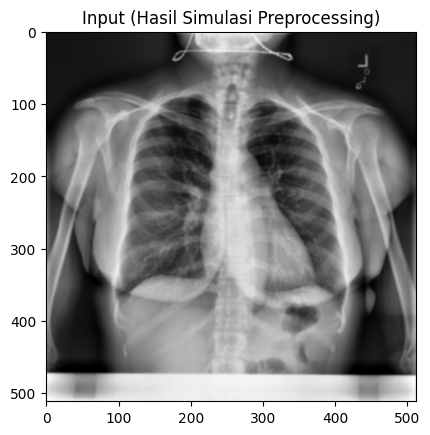

In [9]:
if len(raw_image.shape) > 2:
    img_gray = cv2.cvtColor(raw_image, cv2.COLOR_BGR2GRAY)
else:
    img_gray = raw_image

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
img_clahe = clahe.apply(img_gray)

img_blur = cv2.GaussianBlur(img_clahe, (5, 5), 0)

input_image = img_blur

plt.imshow(input_image, cmap='gray')
plt.title("Input (Hasil Simulasi Preprocessing)")
plt.show()

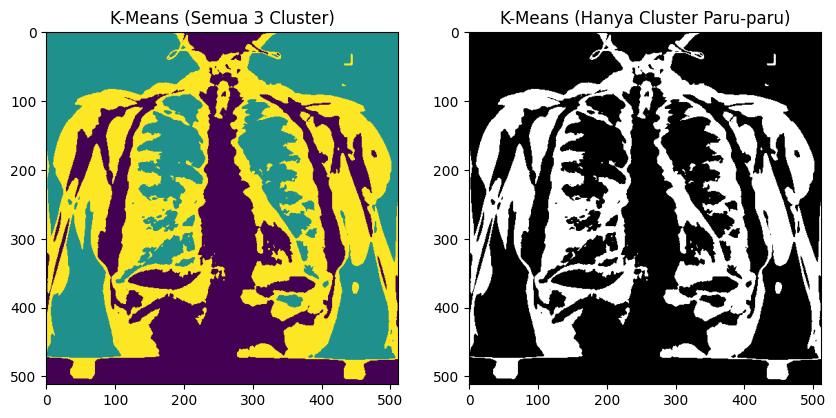

In [3]:
pixels = input_image.reshape((-1, 1)).astype(np.float32)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(pixels)

labels = kmeans.labels_
centers = kmeans.cluster_centers_

labels_img = labels.reshape(input_image.shape)

sorted_center_indices = np.argsort(centers.flatten())
background_cluster = sorted_center_indices[0]
lung_cluster = sorted_center_indices[1] 
bone_cluster = sorted_center_indices[2]

kmeans_mask = (labels_img == lung_cluster).astype(np.uint8) * 255

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(labels_img.astype(np.uint8), cmap='viridis')
plt.title("K-Means (Semua 3 Cluster)")
plt.subplot(1, 2, 2)
plt.imshow(kmeans_mask, cmap='gray')
plt.title("K-Means (Hanya Cluster Paru-paru)")
plt.show()

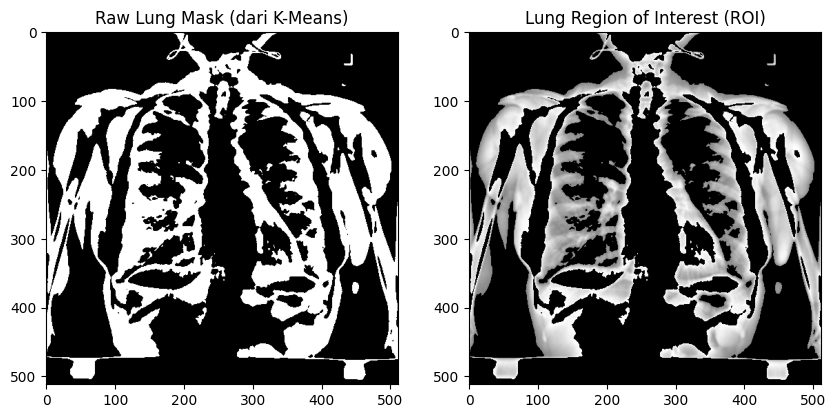

In [4]:
raw_lung_mask = kmeans_mask.astype(np.uint8)

lung_roi = cv2.bitwise_and(input_image, input_image, mask=raw_lung_mask)

# Plot the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(raw_lung_mask, cmap='gray')
plt.title("Raw Lung Mask (dari K-Means)")
plt.subplot(1, 2, 2)
plt.imshow(lung_roi, cmap='gray')
plt.title("Lung Region of Interest (ROI)")
plt.show()

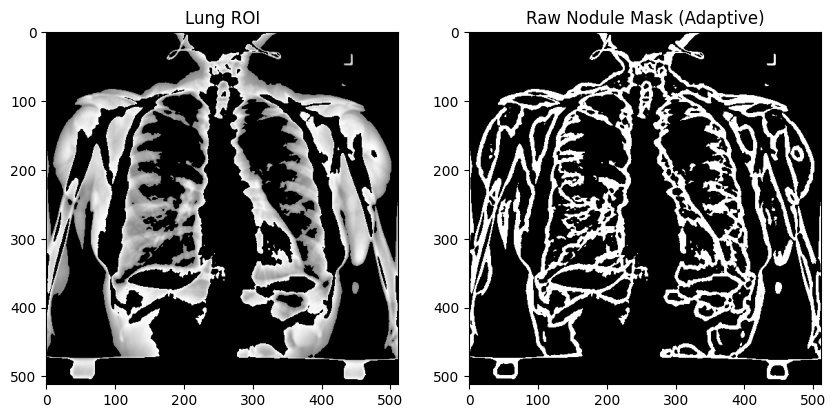

In [5]:
raw_nodule_mask = cv2.adaptiveThreshold(
    lung_roi, 
    255, 
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    cv2.THRESH_BINARY, 
    blockSize=21, 
    C=-5
)

raw_nodule_mask = cv2.bitwise_and(raw_nodule_mask, raw_nodule_mask, mask=raw_lung_mask)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(lung_roi, cmap='gray')
plt.title("Lung ROI")
plt.subplot(1, 2, 2)
plt.imshow(raw_nodule_mask, cmap='gray')
plt.title("Raw Nodule Mask (Adaptive)")
plt.show()

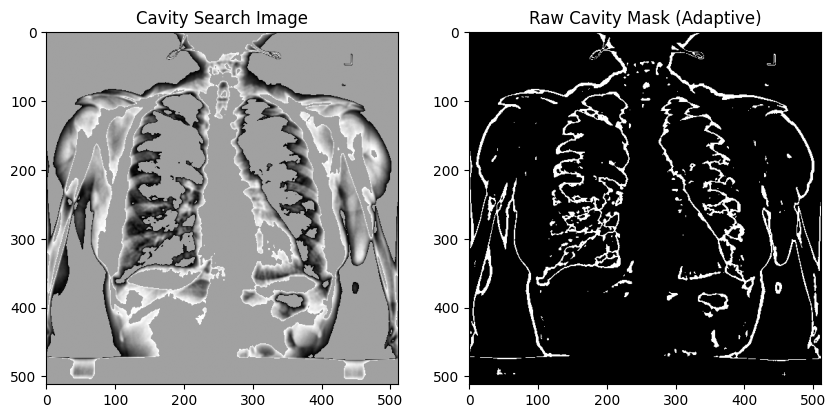

In [6]:
cavity_search_img = lung_roi.copy()
cavity_search_img[raw_lung_mask == 0] = 128

raw_cavity_mask = cv2.adaptiveThreshold(
    cavity_search_img, 
    255, 
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    cv2.THRESH_BINARY_INV, 
    blockSize=21, 
    C=7
)

raw_cavity_mask = cv2.bitwise_and(raw_cavity_mask, raw_cavity_mask, mask=raw_lung_mask)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cavity_search_img, cmap='gray')
plt.title("Cavity Search Image")
plt.subplot(1, 2, 2)
plt.imshow(raw_cavity_mask, cmap='gray')
plt.title("Raw Cavity Mask (Adaptive)")
plt.show()

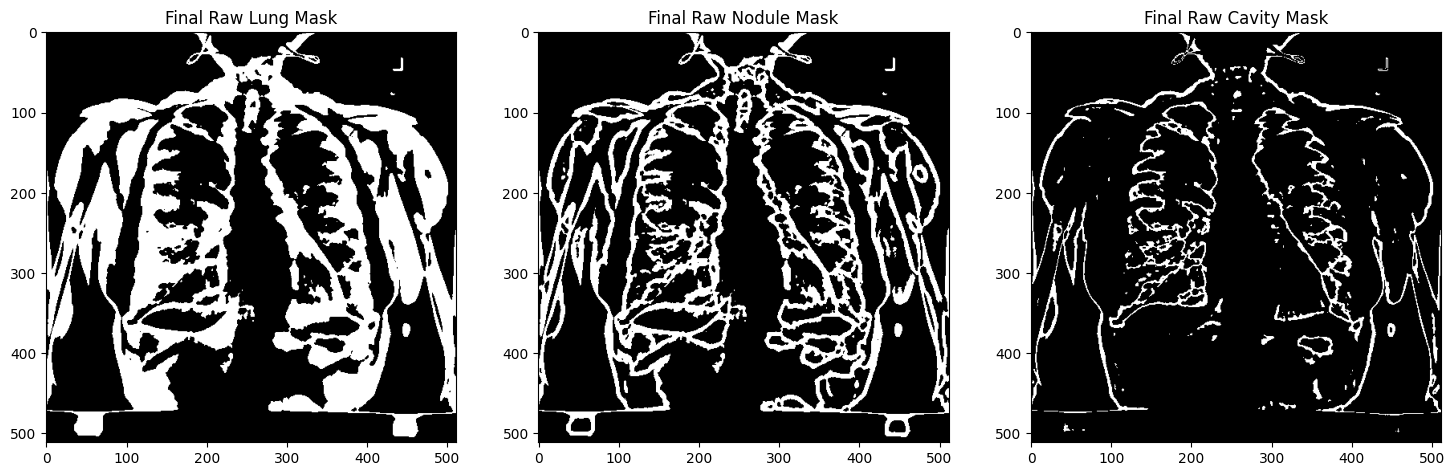

In [7]:
raw_masks_dict = {
    "lung": raw_lung_mask,
    "nodule": raw_nodule_mask,
    "cavity": raw_cavity_mask
}

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(raw_masks_dict['lung'], cmap='gray')
plt.title("Final Raw Lung Mask")

plt.subplot(1, 3, 2)
plt.imshow(raw_masks_dict['nodule'], cmap='gray')
plt.title("Final Raw Nodule Mask")

plt.subplot(1, 3, 3)
plt.imshow(raw_masks_dict['cavity'], cmap='gray')
plt.title("Final Raw Cavity Mask")
plt.show()